## Code assignment

Let us download the BLIP model from HuggingFace transformers library

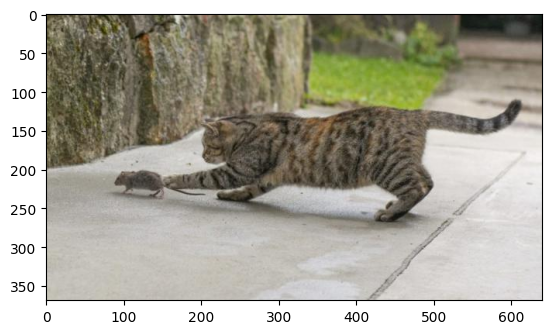

In [ ]:
from PIL import Image
import requests
# Classic image of a cat chasing a mouse

url = "https://s.yimg.com/ny/api/res/1.2/xZG6njHcHN1sfBDYPnQNIA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTM2OQ--/https://media.zenfs.com/en/cat_time_944/a462b52f40d9afdb9ac619626828b6a5"
image = Image.open(requests.get(url, stream=True).raw)

import matplotlib.pyplot as plt
img = plt.imshow(image)


### BLIP for conditional generation

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# We start with conditional generation
processor_cgen = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_cgen = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# We ask the BLIP conditional generator to finish that sentence
text = ["A cat is chasing", "A photo of a"]
inputs = processor_cgen(images=image, text=text, return_tensors="pt").to(device, torch.float16)

outputs = model_cgen.generate(**inputs, max_new_tokens= 60)
generated_texts = processor_cgen.batch_decode(outputs, skip_special_tokens=True)

for answer in generated_texts:
  print(answer)

a cat is chasing a mouse
a photo of a cat chasing a mouse


In [ ]:
# OK answers make sense, but what if we use a tricky sentence? We start to see a weird behavior
text = ["A mouse is chasing a"]
inputs = processor_cgen(images=image, text=text, return_tensors="pt", padding=True).to(device, torch.float16)

outputs = model_cgen.generate(**inputs, max_new_tokens= 60)
generated_texts = processor_cgen.batch_decode(outputs, skip_special_tokens=True)

for answer in generated_texts:
  print(answer)

a mouse is chasing a cat


### BLIP for visual question answering

In [ ]:
from transformers import BlipForQuestionAnswering

model_vqa = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
processor_vqa = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# We ask the BLIP VQA generator to answer the question
text = ["What does the cat do?", "What does the cat chase?", "What does the mouse chase?", "What happens in the photo?"]
inputs = processor_vqa(images=image, text=text, return_tensors="pt", padding=True).to(device, torch.float16)

outputs = model_vqa.generate(**inputs, max_new_tokens= 60)
generated_texts = processor_vqa.batch_decode(outputs, skip_special_tokens=True)

for answer in generated_texts:
  print(answer)

run
mouse
mouse
cat and bird fight


### Robustness of VLMs: a mouse chasing a cat

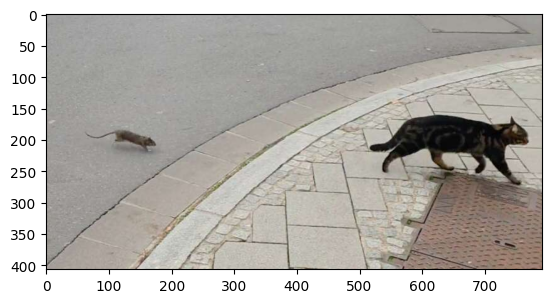

In [ ]:
# Now let us look at the inverted scene, a mouse chases a cat

url="https://assets3.thrillist.com/v1/image/2795422/792x407/flatten;scale;webp=auto;jpeg_quality=60.jpg"
image_2 = Image.open(requests.get(url, stream=True).raw)
img = plt.imshow(image_2)

### Generation failures

In [ ]:
text = ["A cat is chasing", "A mouse is chasing", "A photo of a"]
inputs = processor_cgen(images=image_2, text=text, return_tensors="pt", padding=True).to(device, torch.float16)

outputs = model_cgen.generate(**inputs, max_new_tokens= 60)
generated_texts = processor_cgen.batch_decode(outputs, skip_special_tokens=True)

for answer in generated_texts:
  print(answer)

a cat is chasing a mouse on the sidewalk
a mouse is chasing a cat
a photo of a cat walking on a sidewalk


VQA model failures

In [ ]:
text = ["What does the cat do?", "What does the cat chase?", "What does the mouse chase?", "What happens in the photo?"]
inputs = processor_vqa(images=image_2, text=text, return_tensors="pt").to(device, torch.float16)

outputs = model_vqa.generate(**inputs, max_new_tokens = 60)
generated_texts = processor_vqa.batch_decode(outputs, skip_special_tokens=True)

for answer in generated_texts:
  print(answer)

run
mouse
mouse
cat and mouse fight


### BLIP for image-text retrieval


In [ ]:
from transformers import BlipForImageTextRetrieval

model_itm = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
processor_itm = AutoProcessor.from_pretrained("Salesforce/blip-itm-base-coco")


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/895M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
texts = ["A cat is chasing a mouse", "A mouse is chasing a cat"]
inputs = processor_itm(images=[image_2], text=texts, return_tensors="pt", padding=True)

In [ ]:
outputs = model_itm(**inputs, use_itm_head=True)
gen_scores = torch.softmax(outputs.itm_score,-1)

# Generative scores p(text is relevant|image)
# Each row corresponds to probability of the text being relevant for the image
for i in range(gen_scores.size(0)):
  print(f'"{texts[i]}" has probability {gen_scores[i,1]:.3f}')

outputs = model_itm(**inputs, use_itm_head=False)
cosine_scores = outputs.itm_score.squeeze()

for i in range(cosine_scores.size(0)):
  print(f'"{texts[i]}" has similarity {cosine_scores[i]:.3f}')

"A cat is chasing a mouse" has probability 0.999
"A mouse is chasing a cat" has probability 0.999
"A cat is chasing a mouse" has similarity 0.528
"A mouse is chasing a cat" has similarity 0.533


### BLIP probability of p(text|image)

Now, we will compute the probability of each caption under the generative model, conditioned on the image. There is no direct way to do so but we will use the fact that the generative model is trained on next token prediction, i.e. models $p(x_{t+1}|x_{\le t})$. That is, if we have a tokenized
sequence $X = (x_0, x_1, \dots, x_t)$, then the model is trained to model the with cross-entropy loss

\begin{equation}
CE(X) = \frac{1}{t} \sum_{i=1}^t \log p (x_i|x_{\le i})
\end{equation}


Let us try to call the model's loss directly

In [ ]:
inputs = processor_cgen(images=image, text="A cat is chasing a mouse",
                  return_tensors="pt", padding=True).to(device, torch.float16)

outputs = model_cgen(**inputs, labels = inputs['input_ids']) # needed to pass the inputs
print(outputs.loss.item())

inf


Why is this? Because BLIP training uses *label smoothing*, which gives $\infty$ in this case because of the size of the output vocab.
See
https://github.com/huggingface/transformers/blob/e6dcf8abd6f65bb4b6dfc1831b20d9ba49ce00e2/src/transformers/models/blip/modeling_blip_text.py#L892

When dealing with big librairies, this can happen quite often to have to do some debugging for deep understanding !

In [ ]:
from torch.nn import CrossEntropyLoss
import torch

def return_nll(scores, target):
  loss_fct = CrossEntropyLoss(reduction='mean', label_smoothing=0.0) # we're setting it to 0
  loss = loss_fct(scores, target)
  return loss

def compute_generative_probability(model, processor, image, text):

  inputs = processor(images=image, text=text,
                    return_tensors="pt", padding=True).to(device, torch.float16)
  outputs = model(**inputs, labels=inputs['input_ids'])
  shifted_predictions_scores = outputs.logits[0 , :-1, :].contiguous()
  shifted_labels = inputs["input_ids"][0, 1:].contiguous().to(shifted_predictions_scores.device)
  nll = return_nll(shifted_predictions_scores, target=shifted_labels)

  return nll

loss = compute_generative_probability(model_cgen, processor_cgen, image, "A cat is chasing a mouse")
print("Negative log-likelihood of image 1 and its correct caption", loss.item())

loss = compute_generative_probability(model_cgen, processor_cgen, image_2, "A mouse is chasing a cat")
print("Negative log-likelihood of image 2 and its correct caption", loss.item())

Negative log-likelihood of image 1 and its correct caption 1.10546875
Negative log-likelihood of image 2 and its correct caption 2.326171875


Now, let us look at the image of the mouse chasing the cat, and computing the NLL of "A cat is chasing a mouse"

In [ ]:
loss = compute_generative_probability(model_cgen, processor_cgen, image_2, "A cat is chasing a mouse")
print("Negative log-likelihood of image 2 and its incorrect caption, but which is more probable semantically", loss.item())

Negative log-likelihood of image 2 and its incorrect caption, but which is more probable semantically 1.7041015625


We see there is still a lot to do for VLMs to understand semantics and pragmatics the way humans do...